### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 8
### Due: Saturday, Apr 17th at 11.59pm CST
---

In [117]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15,8
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from astroML.classification import GMMBayes
from scipy.integrate import trapz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Only one problem this week

This problem is mostly about generative classification, but will include one discriminative classifer that we'll meet in `Lecture_20`.

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.


3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*


5. Repeat (4) for Quadratic Discriminant Analysis. 


6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.


7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 


8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 


9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 


10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier. 


# Solution

1. Use the following code snippet to read in SDSS galaxy color data.
```
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()
```
This is a structured numpy array. Find and print all of the column names. Using the data, create arrays of $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create arrays of redshift and the spectral class. How many regular galaxies and how many quasars are in this sample?

In [83]:
from astroML.datasets import fetch_sdss_galaxy_colors
data = fetch_sdss_galaxy_colors()

print(data.dtype)
ug=data['u']-data['g']
gr=data['g']-data['r']
ri=data['r']-data['i']
iz=data['i']-data['z']
redshift=data['redshift']
labels=data['specClass']
labels_01=np.where(labels=='GALAXY',0,1) #galaxy is 0, QSO is 1

[('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('specClass', '<U6'), ('redshift', '<f8'), ('redshift_err', '<f8')]


2. Make a scatter plot of $(u-g)$ versus $(g-r)$, color coding by galaxy or quasar class. The plot should include appropriate axis labels and a legend. Set `xlim` between -0.5 and 2.5, and `ylim` between -0.5 and 1.5.

Text(0, 0.5, '(g-r)')

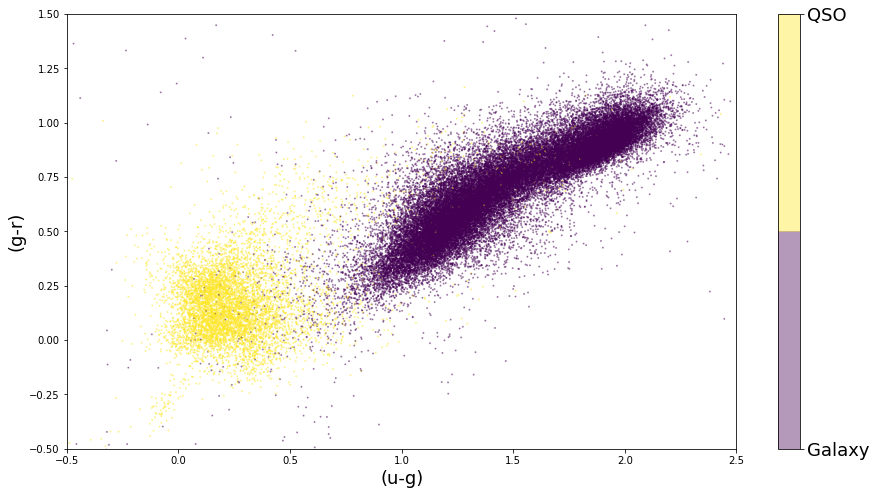

In [84]:
plt.axis([-0.5,2.5,-0.5,1.5])
plt.scatter(ug,gr,c=labels_01,cmap=plt.cm.get_cmap('viridis', 2),alpha=0.4,s=1)
cbar=plt.colorbar(ticks=[0,1])
cbar.ax.set_yticklabels(['Galaxy','QSO'],fontsize=18)
plt.xlabel('(u-g)',fontsize=18)
plt.ylabel('(g-r)',fontsize=18)

3. Stack all colors and the redshift into a data matrix, $X$. Create a target label array that has $0$ for a regular galaxy and $1$ for a quasar. Perform a train-test split, taking $20\%$ of the data for testing.

In [85]:
# num_features is 5 (u-g,g-r,r-i,i-z,redshift)
num_features=5
num_samples=len(ug)
X=np.zeros(shape=(num_samples,num_features))
X[:,0]=ug
X[:,1]=gr
X[:,2]=ri
X[:,3]=iz
X[:,4]=redshift

y=labels_01

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40000, 5)
(10000, 5)
(40000,)
(10000,)


4. Create a compact `for` loop that iterates over the fitting of a Gaussian Naive Bayes classification algorithm to successively more features of the data. Within the loop, compute and plot an ROC curve. The end result should be a plot showing ROC curves for GNB classification with more and more features of the data, with appropriate axis labels and a legend. Use `xlim` between 0 and 0.01. Which feature seems to make the classification trivially easy? *Note: `predict_proba` returns an array with as many columns as classes. You've labeled quasars as $1$, so for the ROC curve you must make sure to access the relevant quasar probability-- you can find this by accessing the **classes_** attribute of the estimator.*

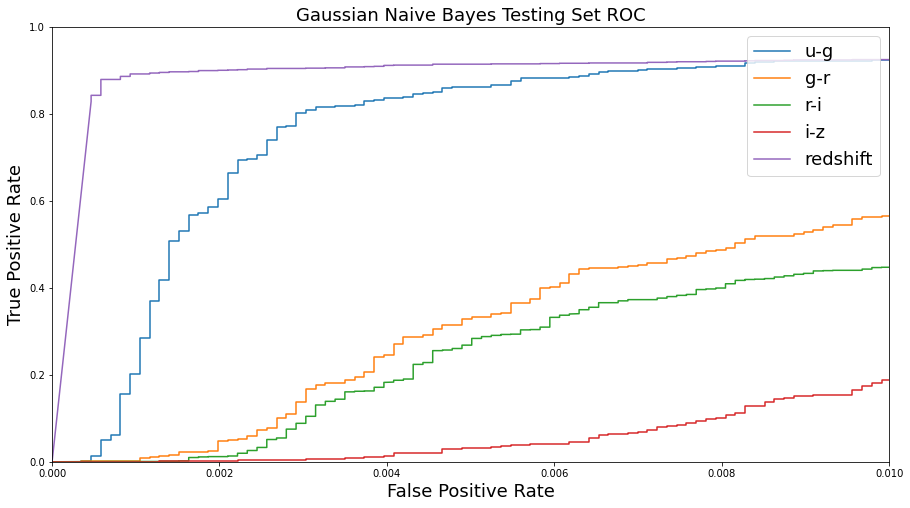

In [89]:
labels=['u-g','g-r','r-i','i-z','redshift']
for n in range(num_features):
    # Splice data
    X_train_iter=X_train[:,n].reshape(X_train.shape[0],1)
    X_test_iter=X_test[:,n].reshape(X_test.shape[0],1)
    # Fit Gaussian Naive Bayes
    clf = GaussianNB()
    clf.fit(X_train_iter,y_train)
    # Create ROC
    probs=clf.predict_proba(X_test_iter)
    QSO_probs=probs[:,1]
    
    # roc_curve accepts positive class probabilities for y_score
    fpr,tpr,thresholds=roc_curve(y_test,QSO_probs,pos_label=1)
    
    plt.plot(fpr,tpr,label=labels[n])

plt.axis([0,0.01,0,1])
plt.legend(loc='upper right',fontsize=18)
plt.title('Gaussian Naive Bayes Testing Set ROC',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.show()

<font color='blue'>The redshift seems to make classification trivially easy. Apart from that, u-g has the most predictive power</font>

5. Repeat (4) for Quadratic Discriminant Analysis. 

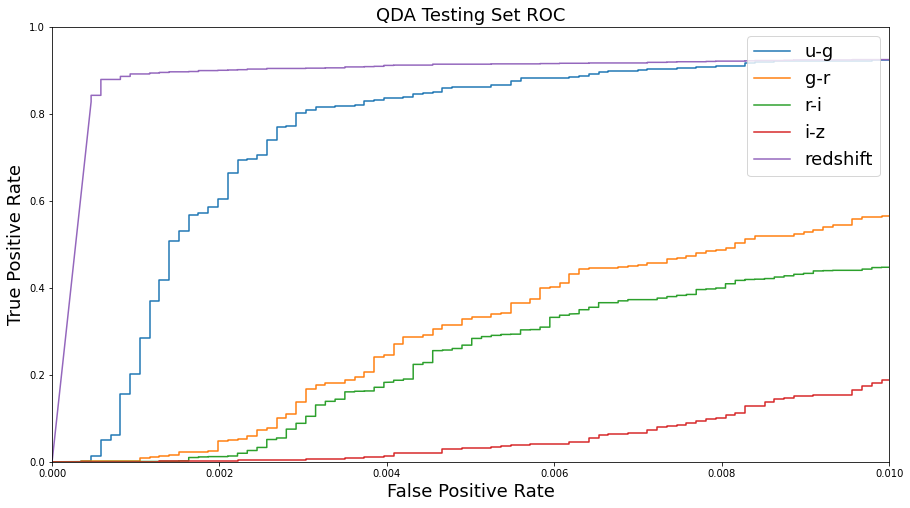

In [90]:
labels=['u-g','g-r','r-i','i-z','redshift']
for n in range(num_features):
    # Splice data
    X_train_iter=X_train[:,n].reshape(X_train.shape[0],1)
    X_test_iter=X_test[:,n].reshape(X_test.shape[0],1)
    # Fit QDA
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X_train_iter,y_train)
    # Create ROC
    probs=clf.predict_proba(X_test_iter)
    QSO_probs=probs[:,1]
    
    # roc_curve accepts positive class probabilities for y_score
    fpr,tpr,thresholds=roc_curve(y_test,QSO_probs,pos_label=1)
    
    plt.plot(fpr,tpr,label=labels[n])

plt.axis([0,0.01,0,1])
plt.legend(loc='upper right',fontsize=18)
plt.title('QDA Testing Set ROC',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.show()

6. Let's try classification with GMM Bayes. Restrict the training and testing to be just on the $4$ colors. Iterate now over number of components in the GMM Bayes fit up to $10$, plotting ROC curves for all, and find the number of components that gives the best performance.

In [92]:
X_train_colors=X_train[:,:4]
X_test_colors=X_test[:,:4]
print(X_train_colors.shape)
print(X_test_colors.shape)

(40000, 4)
(10000, 4)


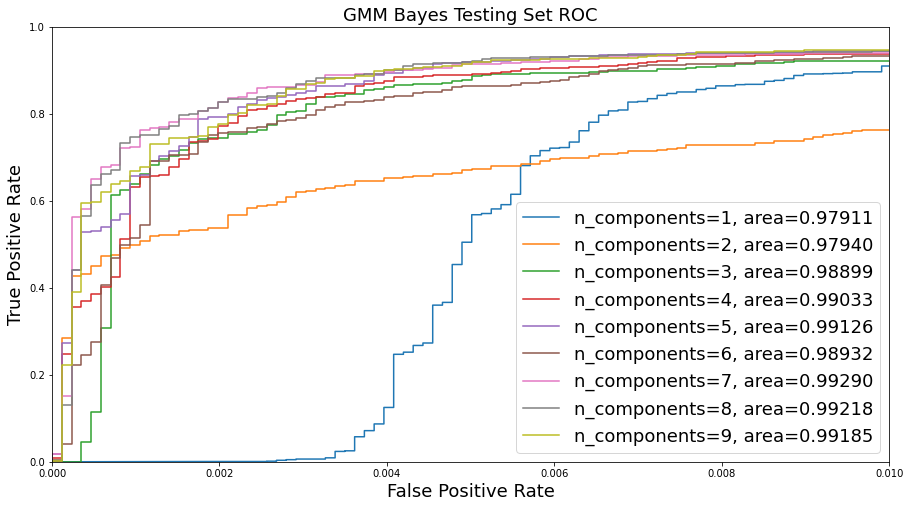

In [109]:
num_components=10
for n in range(1,num_components):
    
    #fit model
    clf=GMMBayes(n_components=n)
    clf.fit(X_train_colors,y_train)
    
    # Create ROC
    probs=clf.predict_proba(X_test_colors)
    QSO_probs=probs[:,1]
    
    # roc_curve accepts positive class probabilities for y_score
    fpr,tpr,thresholds=roc_curve(y_test,QSO_probs,pos_label=1)
    
    area_under_curve=trapz(y=tpr,x=fpr)
    
    plt.plot(fpr,tpr,label='n_components={:.0f}, area={:.5f}'.format(n,area_under_curve))
    
plt.axis([0,0.01,0,1])
plt.legend(loc='lower right',fontsize=18)
plt.title('GMM Bayes Testing Set ROC',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.show()

<font color='blue'>7 components per class seems to be ideal.</font>

7. Repeat (6) for $K$-nearest neighbor classification, looping over number of neighbors between 5 and 100 in steps of 10. Find the number that gives the best performance. 

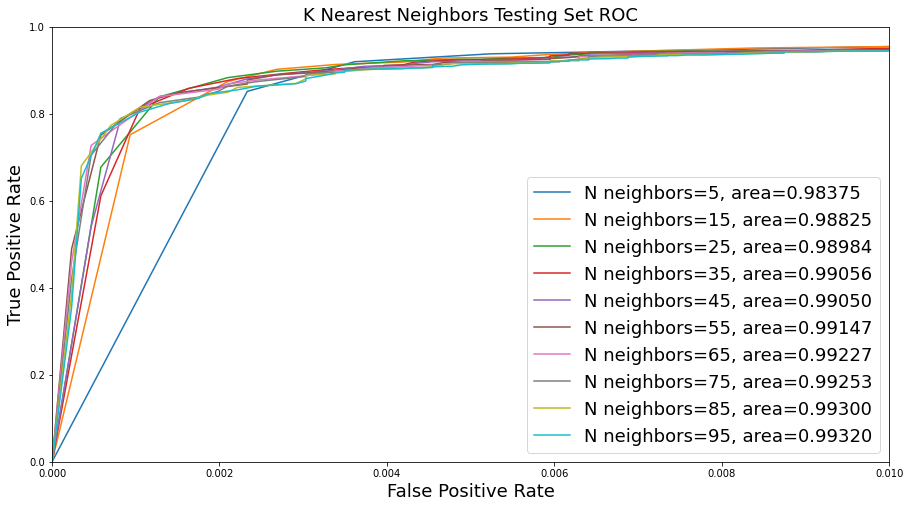

In [116]:
k_neighbors=np.arange(5,100,step=10)

for k in k_neighbors:
    
    #fit model
    clf=KNeighborsClassifier(k)
    clf.fit(X_train_colors,y_train)
    
    # Create ROC
    probs=clf.predict_proba(X_test_colors)
    QSO_probs=probs[:,1]
    
    # roc_curve accepts positive class probabilities for y_score
    fpr,tpr,thresholds=roc_curve(y_test,QSO_probs,pos_label=1)
    
    area_under_curve=trapz(y=tpr,x=fpr)
    
    plt.plot(fpr,tpr,label='N neighbors={:.0f}, area={:.5f}'.format(k,area_under_curve))
    
plt.axis([0,0.01,0,1])
plt.legend(loc='lower right',fontsize=18)
plt.title('K Nearest Neighbors Testing Set ROC',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.show()

<font color='blue'>K=95 gives the best performance</font>

8. Repeat (6) for Decision Tree classification, looping over the maximum tree depth between 1 and 10. Find the number that gives the best performance. 

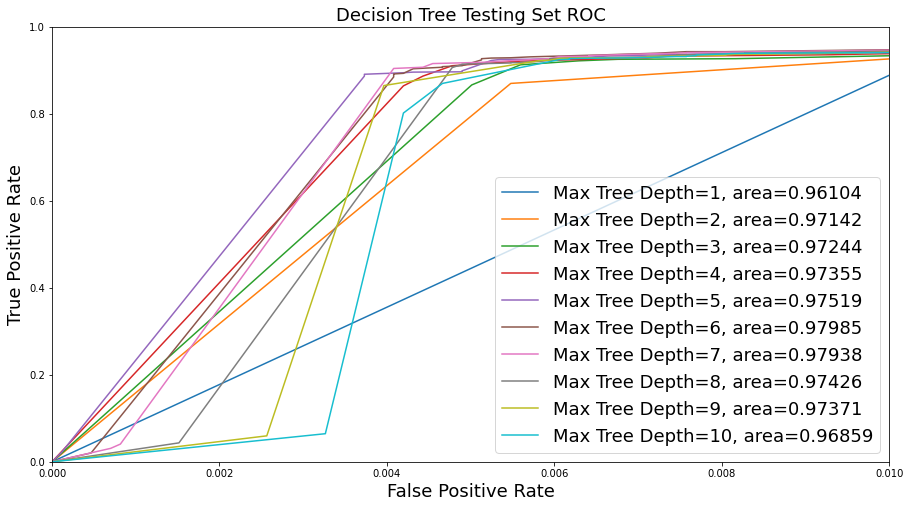

In [119]:
max_depth=np.arange(1,11)

for d in max_depth:
    
    #fit model
    clf=DecisionTreeClassifier(max_depth=d)
    clf.fit(X_train_colors,y_train)
    
    # Create ROC
    probs=clf.predict_proba(X_test_colors)
    QSO_probs=probs[:,1]
    
    # roc_curve accepts positive class probabilities for y_score
    fpr,tpr,thresholds=roc_curve(y_test,QSO_probs,pos_label=1)
    
    area_under_curve=trapz(y=tpr,x=fpr)
    
    plt.plot(fpr,tpr,label='Max Tree Depth={:.0f}, area={:.5f}'.format(d,area_under_curve))
    
plt.axis([0,0.01,0,1])
plt.legend(loc='lower right',fontsize=18)
plt.title('Decision Tree Testing Set ROC',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.show()

<font color='blue'>Max tree depth=6 gives the best performance</font>

9. Finally, plot the ROC curves for GNB, QDA, and the best-performing GMMBayes, KNN, and DT classification algorithms, all using just the 4 colors. What is the overall best-performing classifier? 

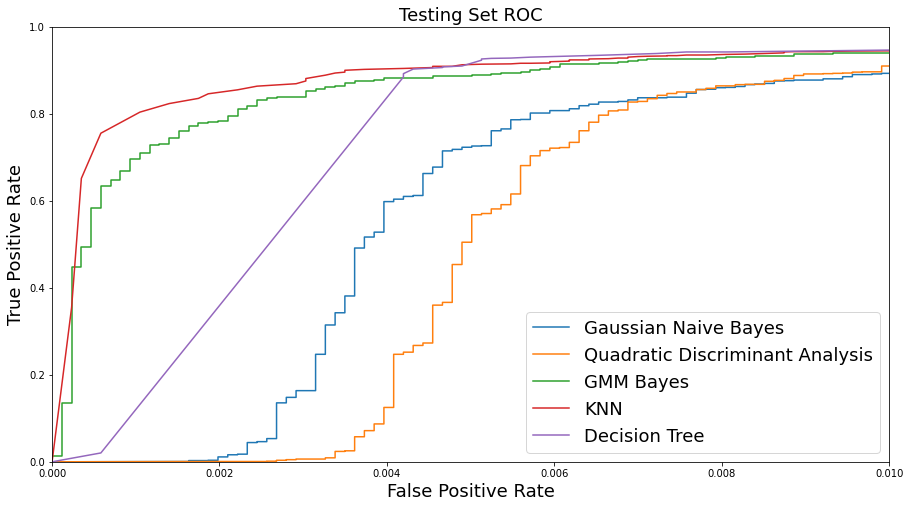

In [126]:
classifiers=[GaussianNB(),
             QuadraticDiscriminantAnalysis(),
             GMMBayes(n_components=7),
             KNeighborsClassifier(95),
             DecisionTreeClassifier(max_depth=6)]

labels=['Gaussian Naive Bayes','Quadratic Discriminant Analysis','GMM Bayes','KNN','Decision Tree']


for i in range(len(classifiers)):
    #fit model
    clf=classifiers[i]
    clf.fit(X_train_colors,y_train)
    
    # Create ROC
    probs=clf.predict_proba(X_test_colors)
    QSO_probs=probs[:,1]
    
    # roc_curve accepts positive class probabilities for y_score
    fpr,tpr,thresholds=roc_curve(y_test,QSO_probs,pos_label=1)
    
    plt.plot(fpr,tpr,label=labels[i])
    
plt.axis([0,0.01,0,1])
plt.legend(loc='lower right',fontsize=18)
plt.title('Testing Set ROC',fontsize=18)
plt.xlabel('False Positive Rate',fontsize=18)
plt.ylabel('True Positive Rate',fontsize=18)
plt.show()
    

<font color='blue'>KNN is the best performing classifier</font>

10. Make a 2-panel plot, showing in the left panel the color-coded training data in $(u-g)$ versus $(g-r)$ (similar to item 2 above), and in the right panel the same features of the testing data color coded by their predicted class from the tuned best-performing classifier.

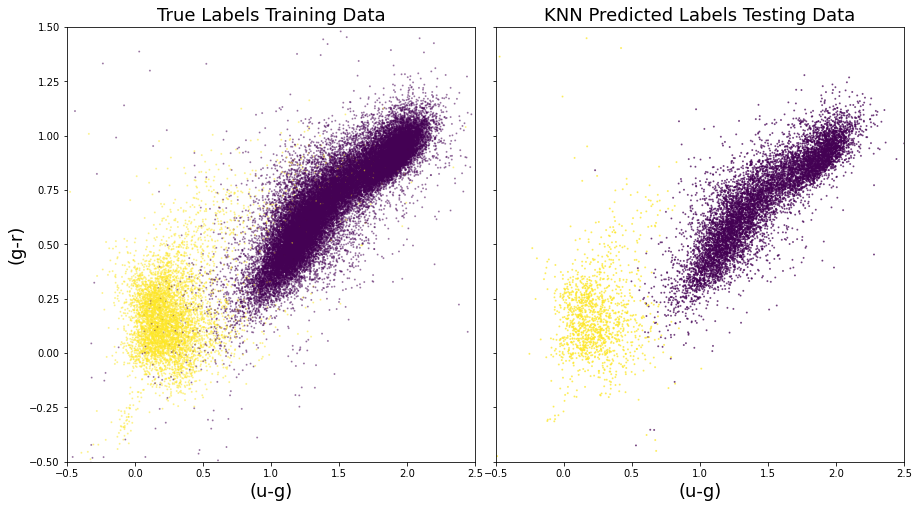

In [146]:
fig,axs=plt.subplots(nrows=1,ncols=2,sharey=True)

axs[0].scatter(X_train_colors[:,0],X_train_colors[:,1],c=y_train,cmap=plt.cm.get_cmap('viridis', 2),alpha=0.4,s=1)
axs[0].set_xlabel('(u-g)',fontsize=18)
axs[0].set_ylabel('(g-r)',fontsize=18)
axs[0].set_xlim(-0.5,2.5)
axs[0].set_ylim(-0.5,1.5)
axs[0].set_title('True Labels Training Data',fontsize=18)

clf=KNeighborsClassifier(95)
clf.fit(X_train_colors,y_train)

y_pred=clf.predict(X_test_colors)
axs[1].scatter(X_test_colors[:,0],X_test_colors[:,1],c=y_pred,cmap=plt.cm.get_cmap('viridis', 2),alpha=0.6,s=1)
axs[1].set_xlabel('(u-g)',fontsize=18)
axs[1].set_xlim(-0.5,2.5)
axs[1].set_ylim(-0.5,1.5)
axs[1].set_title('KNN Predicted Labels Testing Data',fontsize=18)

plt.subplots_adjust(wspace=0.05)
